## Q1: I love pip 

- Take a piece of python code you wrote (for instance pick one of the exercises you've done for this class). 
- Turn it into a module
- Install it locally
- Deploy on pypi (only using the test-pypi server!)

<div class="alert alert-block alert-warning">
<span class="fa fa-flash"></span> VERY IMPORTANT
    
Both the pypi and test-pypi server are public on the web! Don't compromise your research by putting up something your competitors can use and steal your idea before you've published a paper on it!!! 

</div>

## Solution:

I have turned `poker_odds.py` from L01 into a module and installed it locally.

Here's a screenshot of the installation process succesfully working:

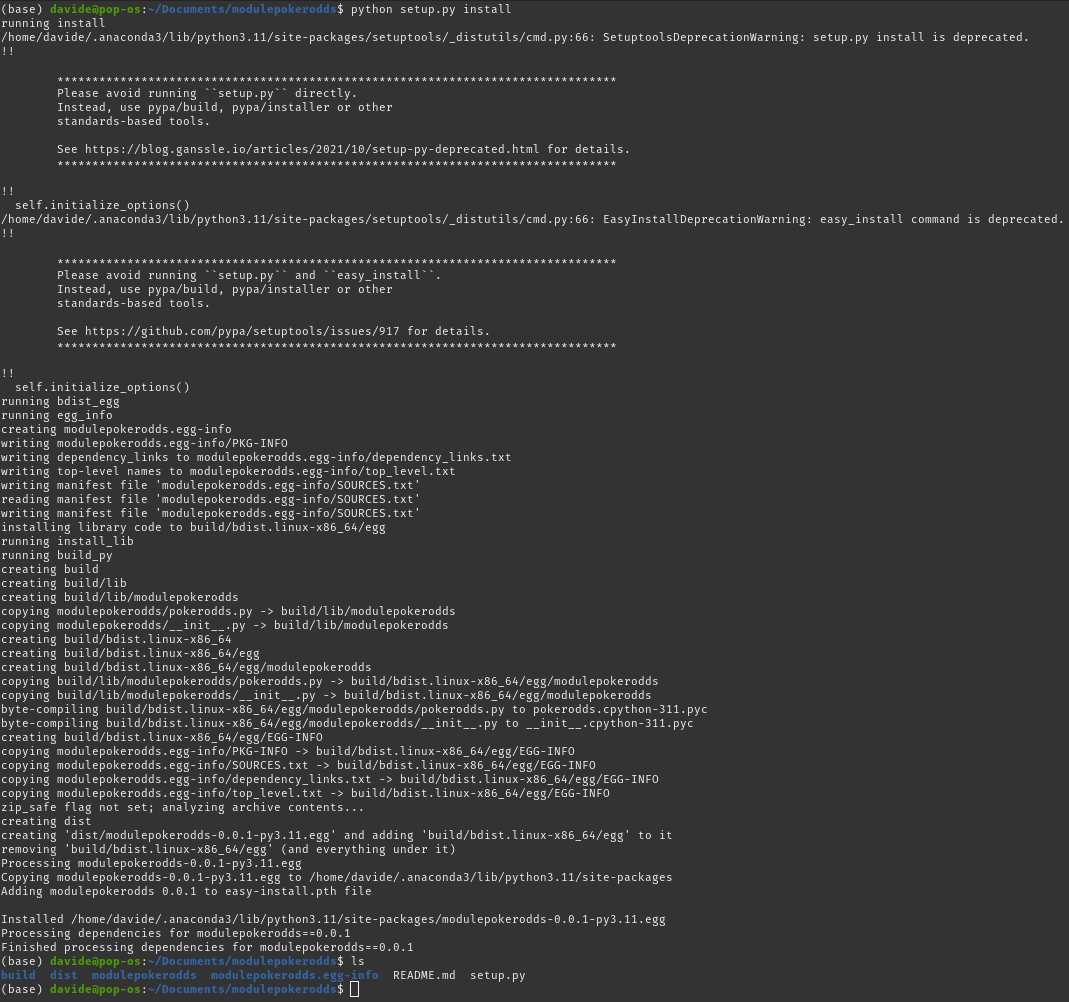

The following block of code now works on my machine

In [1]:
import modulepokerodds as po
print(po.__file__)

# initialize things
one_pairs = 0
two_pairs = 0
threes = 0
fours = 0
houses = 0
total = 1e5
mydeck = po.Deck()

# draw many hands and check for particular poker hands
for _ in range(int(total)):
    mydeck.shuffle()
    hand = mydeck.get_cards(5)
    one_pairs += po.one_pair(hand)
    two_pairs += po.two_pair(hand)
    threes += po.three_of_a_kind(hand)
    fours += po.four_of_a_kind(hand)
    houses += po.full_house(hand)

# print results
print(f"One pair odds estimate: {one_pairs/total*100:.3g}%" )
print("Actual odds: 42.3%")
print(f"Two pair odds estimate: {two_pairs/total*100:.3g}%" )
print("Actual odds: 4.75%")
print(f"3-of-a-kind odds estimate: {threes/total*100:.3g}%" )
print("Actual odds: 2.11%")
print(f"Full house odds estimate: {houses/total*100:.3g}%" )
print("Actual odds: 0.144%")
print(f"4-of-a-kind odds estimate: {fours/total*100:.3g}%" )
print("Actual odds: 0.0240%")

/home/davide/.anaconda3/lib/python3.11/site-packages/modulepokerodds/__init__.py
One pair odds estimate: 42.2%
Actual odds: 42.3%
Two pair odds estimate: 4.75%
Actual odds: 4.75%
3-of-a-kind odds estimate: 2.11%
Actual odds: 2.11%
Full house odds estimate: 0.146%
Actual odds: 0.144%
4-of-a-kind odds estimate: 0.021%
Actual odds: 0.0240%


Here's a screenshot of that too:

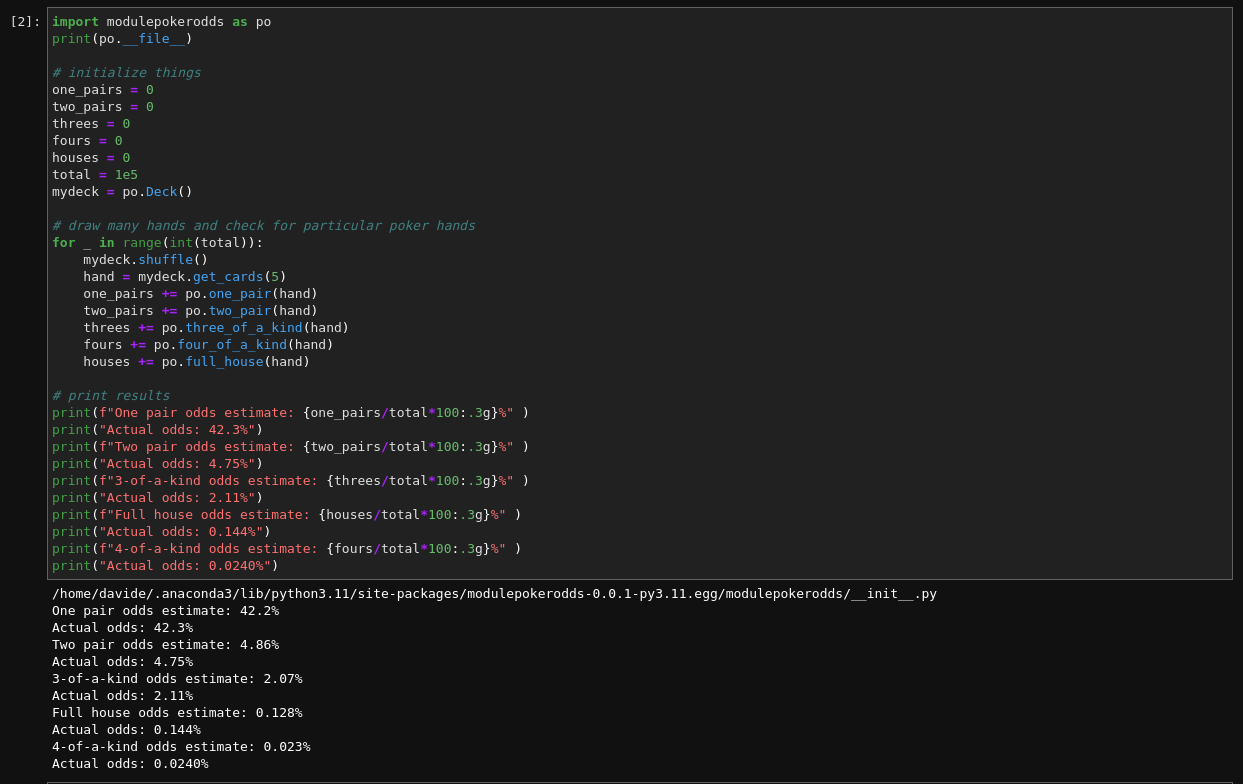

I will now deploy it on PyPI:

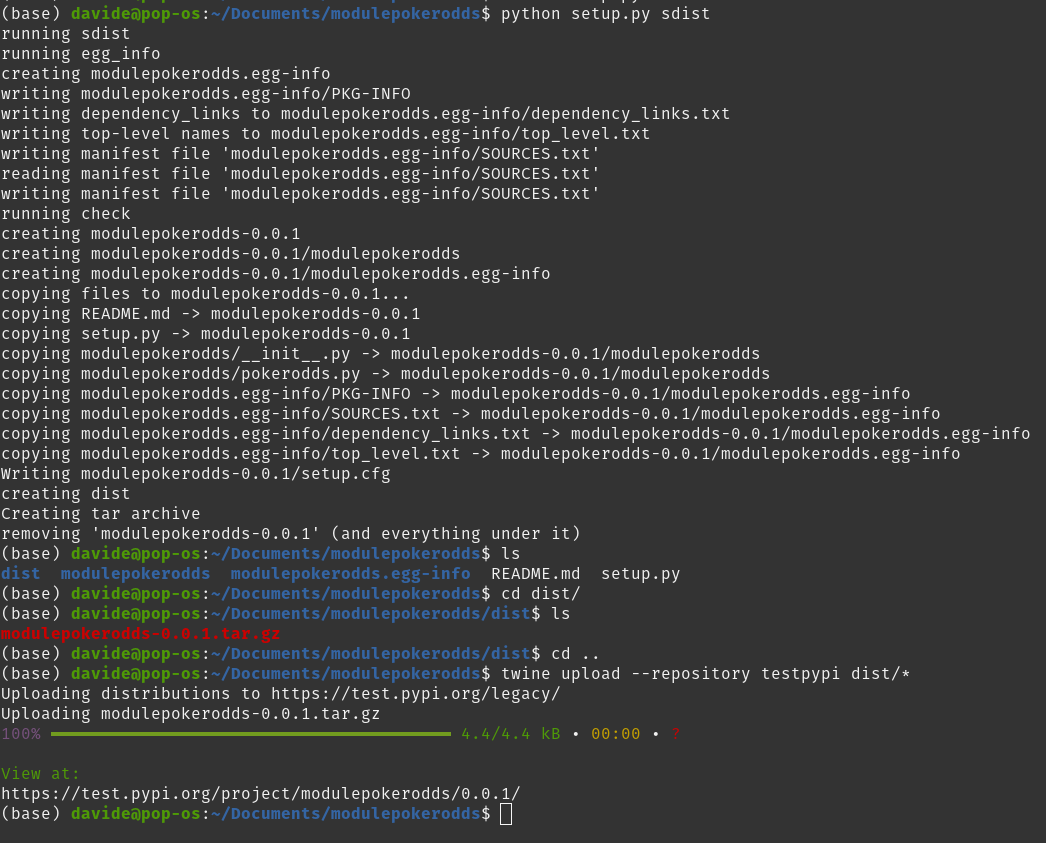

Here it is: [https://test.pypi.org/project/modulepokerodds/0.0.1/](https://test.pypi.org/project/modulepokerodds/0.0.1/)

The module can now be installed with `pip install -i https://test.pypi.org/simple/ modulepokerodds==0.0.1`

The code block above should now be runnable for you too.

## Q4: It's over Anakin, I have the high ground. I hate you! 

Pick a piece of your code that your really hate.  You hate it because it's soooooo slooooow. 
- Profile it.
- Find the culprit
- Rewrite that bottleneck making a better use of numpy arrays, or jitting it with Numba.
- Enjoy your faster code

**You underestimate my power**.

## Solution:
I can't think of a piece of python code that I regularly use which is excruciatingly slow, but some time ago I wrote some code to plot data from a cosmological simulation of about 4000 massive black holes and I remember it taking quite some time. The idea was to plot the contribution of each accretion mass channel for all of the black holes, and then quickly skim through the plots to visually find outliers.

Of course I expect that most of the time is spent on making and saving the plots.

I begin by putting all of the code inside the function `everything()` and then profiling it (running on a smaller subset of 50 black holes):

```python
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})
import os
import yt

def everything():

	ds=yt.load('output_00001/info_00001.txt')

	# directory containing the files
	directory = './test_profile/'

	# get all files starting with "BH" and ending with ".csv"
	files = [file for file in os.listdir(directory) if file.startswith('BH') and file.endswith('.csv') and not file.startswith('BH00000')]

	for file in files:
		print(file)
		data = np.loadtxt(os.path.join(directory, file), usecols=(41, 39, 0, 53), skiprows=1, unpack=True, delimiter=",")

		time, dMtde, M, delta_t = data

		# removing first element because dMtot is going to be one short
		time = time[1:]
		dMtde = dMtde[1:]
		delta_t = delta_t[1:]

		dMtot = np.diff(M) # evaluates the difference between elements of M
		dMtot_no_tde = dMtot - dMtde * delta_t	# removes the contribution of TDEs, dMtde is the rate (mass over time)
		dMgas = np.where(dMtot_no_tde >= 1e5, 0, dMtot_no_tde) # sets the contribution of gas to 0 if the increase is larger than 1e5, otherwise it is dMtot_no_tde

		# dividing by time-step to obtain the rates
		dMtot /= delta_t
		dMgas /= delta_t
		
		fig = plt.figure(figsize=(18.3, 10.3))
		ax1 = fig.add_subplot(211)

		ax1.set_xlabel(r"$t [\mathrm{Gyr}]$")
		ax1.set_ylabel(r"mass growth rate $[\mathrm{M}_\odot / \mathrm{yr}]$")

		ax1.set_yscale("log")

		ax1.plot(time, dMtot, label="total")
		ax1.plot(time, dMgas, label="gas")
		ax1.plot(time, dMtde, label="tde")

		ax1.legend(loc="lower left")
		

		dMtot *= delta_t
		dMgas *= delta_t
		dMtde *= delta_t

		Mtot = np.cumsum(dMtot)
		Mgas = np.cumsum(dMgas)
		Mtde = np.cumsum(dMtde)
		
		ax2 = fig.add_subplot(212)

		ax2.set_xlabel(r"$t [\mathrm{Gyr}]$")
		ax2.set_ylabel(r"accreted mass $[\mathrm{M}_\odot]$")

		ax2.set_yscale("log")

		ax2.plot(time, Mtot, label="total")
		ax2.plot(time, Mgas, label="gas")
		ax2.plot(time, Mtde, label="tde")

		ax2.legend(loc="lower right")

		redshifts = np.array([100, 30, 20, 15.5, 10, 9, 8, 7, 6, 5, 4, 3.5, 3, 2, 1, 0])
		z_ticks = [ds.cosmology.t_from_z(z).in_units('Gyr') for z in redshifts]

		axr = ax1.twiny()
		axr.set_xlabel(r"$z$")
		axr.set_xticks(z_ticks)
		axr.set_xticklabels(['${:g}$'.format(z) for z in redshifts])

		axr2 = ax2.twiny()
		axr2.set_xlabel(r"$z$")
		axr2.set_xticks(z_ticks)
		axr2.set_xticklabels(['${:g}$'.format(z) for z in redshifts])

		tmin, tmax = time[0]-(time[-1]-time[0])/20, time[-1]+(time[-1]-time[0])/20
		ax2.set_xlim(tmin, tmax)
		axr.set_xlim(tmin, tmax)
		axr2.set_xlim(tmin, tmax)
		ax1.set_xlim(tmin, tmax)

		plt.tight_layout()

		plt.savefig("./test_profile/" + file[:-4] + ".png", dpi=100)

		plt.close(fig)
		
	return
	
import cProfile 
with cProfile.Profile() as pr:
    everything()  

pr.dump_stats("example.prof")	
```
This is what I get:

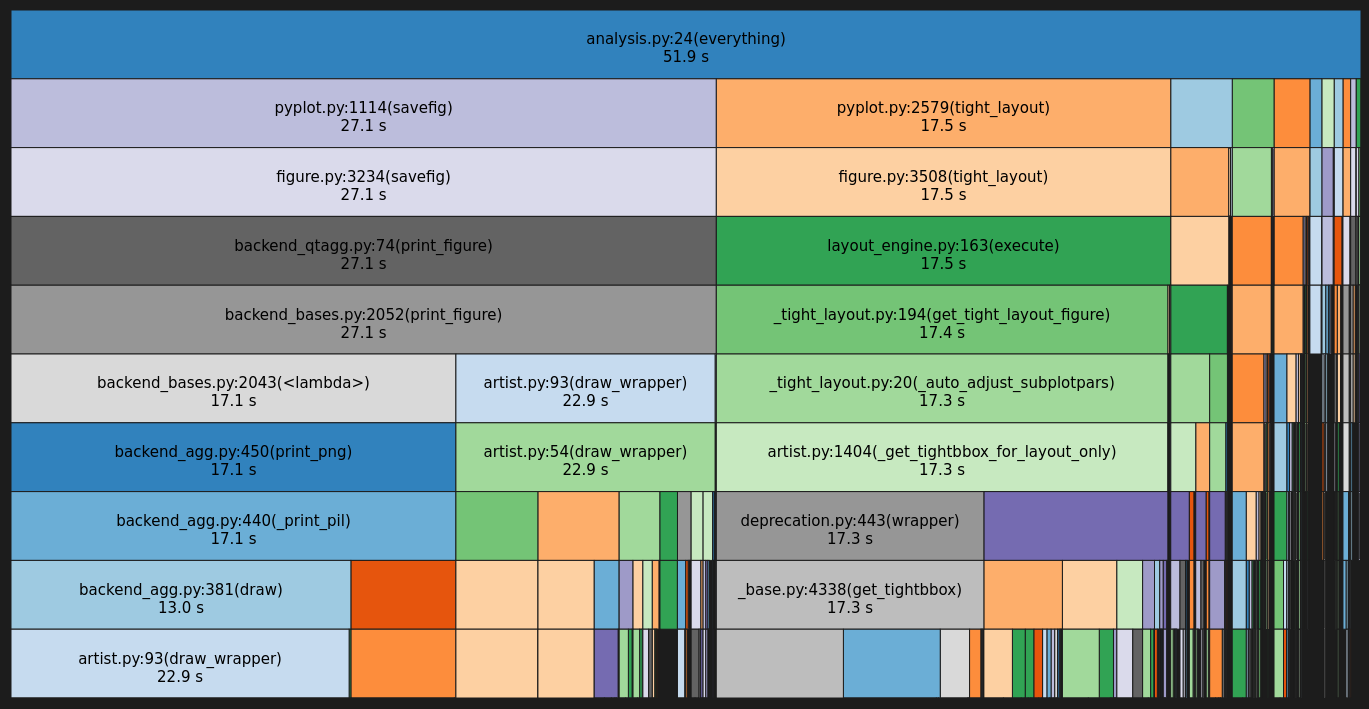

As expected, saving the plots takes a good chunk of the total time, however I was surprised by the fact that calling `plt.tight_layout()` is also wasting so much time. I don't really need the plots to look perfectly clean for a quick analysis, so I can just remove that line of code to significantly speed up things. I will also comment the line where I'm saving the plots and profile everything again:

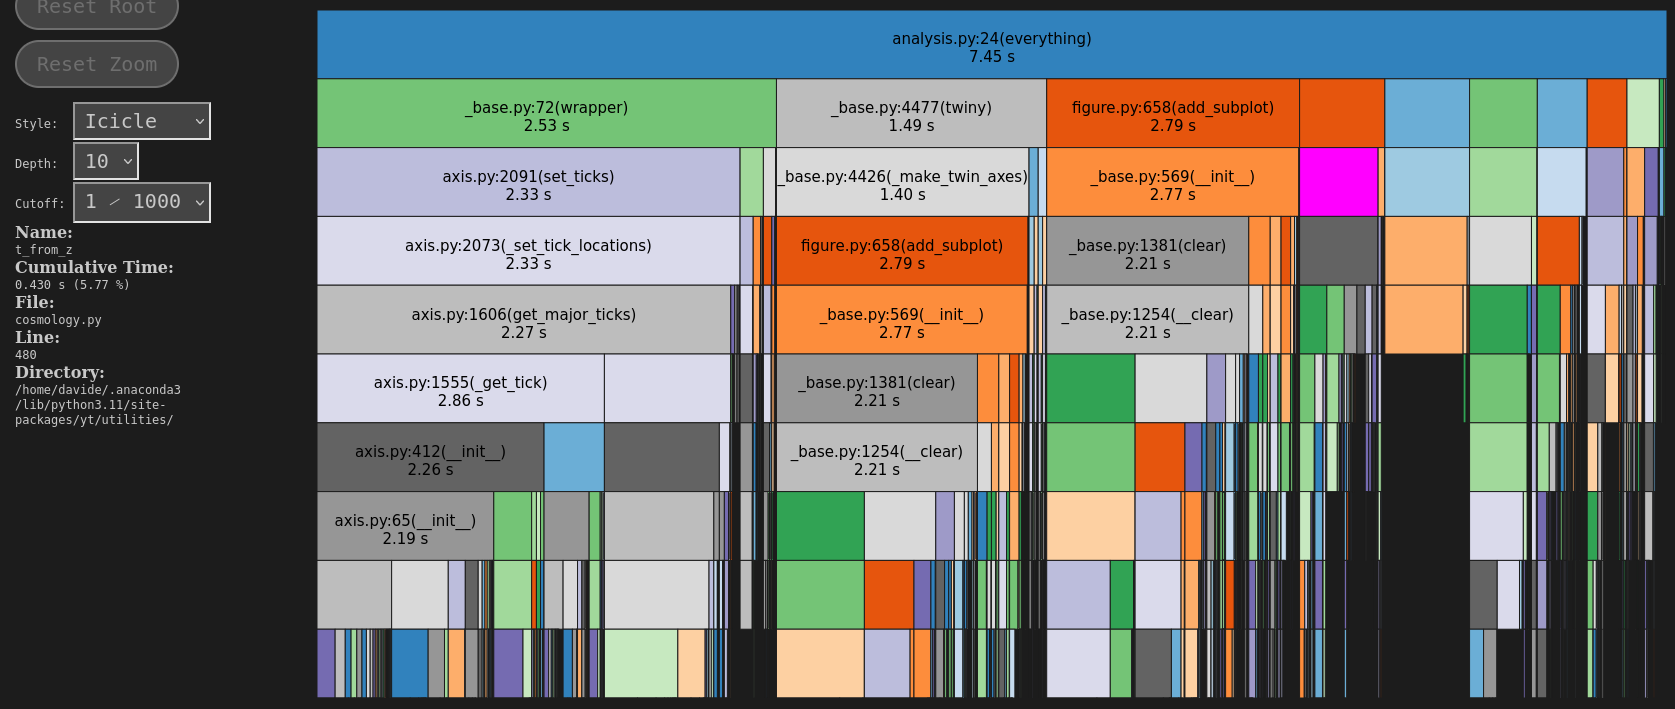

Now it looks like the bottlenecks are the redshift ticks and the subplots.

This makes me realize that I can speed up things by reusing the same figure and axes over and over again by simply cleaning them at the end of each loop instead of building a whole new figure each time. Also, there is no need of computing the redshift ticks each time, as they always are the same. I can thus move some things outside of the for loop:

```python
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})
import os
import yt

def everything():

	ds=yt.load('output_00001/info_00001.txt')

	# Directory containing the files
	directory = './test_profile/'

	# Get all files starting with "BH" and ending with ".csv"
	files = [file for file in os.listdir(directory) if file.startswith('BH') and file.endswith('.csv') and not file.startswith('BH00000')]
	
	fig = plt.figure(figsize=(18.3, 10.3))
	ax1 = fig.add_subplot(211)
	ax2 = fig.add_subplot(212)

	redshifts = np.array([100, 30, 20, 15.5, 10, 9, 8, 7, 6, 5, 4, 3.5, 3, 2, 1, 0])
	z_ticks = [ds.cosmology.t_from_z(z).in_units('Gyr') for z in redshifts]

	axr = ax1.twiny()
	axr.set_xlabel(r"$z$")
	axr.set_xticks(z_ticks)
	axr.set_xticklabels(['${:g}$'.format(z) for z in redshifts])

	axr2 = ax2.twiny()
	axr2.set_xlabel(r"$z$")
	axr2.set_xticks(z_ticks)
	axr2.set_xticklabels(['${:g}$'.format(z) for z in redshifts])

	for file in files:
		print(file)
		data = np.loadtxt(os.path.join(directory, file), usecols=(41, 39, 0, 53), skiprows=1, unpack=True, delimiter=",")

		time, dMtde, M, delta_t = data

		# removing first element because dMtot is going to be one short
		time = time[1:]
		dMtde = dMtde[1:]
		delta_t = delta_t[1:]

		dMtot = np.diff(M) # evaluates the difference between elements of M
		dMtot_no_tde = dMtot - dMtde * delta_t	# removes the contribution of TDEs, dMtde is the rate (mass over time)
		dMgas = np.where(dMtot_no_tde >= 1e5, 0, dMtot_no_tde) # sets the contribution of gas to 0 if the increase is larger than 1e5, otherwise it is dMtot_no_tde

		# divide by time-step to obtain the rates
		dMtot /= delta_t
		dMgas /= delta_t
		
        
		ax1.set_xlabel(r"$t [\mathrm{Gyr}]$")
		ax1.set_ylabel(r"mass growth rate $[\mathrm{M}_\odot / \mathrm{yr}]$")

		ax1.set_yscale("log")

		ax1.plot(time, dMtot, label="total")
		ax1.plot(time, dMgas, label="gas")
		ax1.plot(time, dMtde, label="tde")

		ax1.legend(loc="lower left")
		

		dMtot *= delta_t
		dMgas *= delta_t
		dMtde *= delta_t

		Mtot = np.cumsum(dMtot)
		Mgas = np.cumsum(dMgas)
		Mtde = np.cumsum(dMtde)

		ax2.set_xlabel(r"$t [\mathrm{Gyr}]$")
		ax2.set_ylabel(r"accreted mass $[\mathrm{M}_\odot]$")

		ax2.set_yscale("log")

		ax2.plot(time, Mtot, label="total")
		ax2.plot(time, Mgas, label="gas")
		ax2.plot(time, Mtde, label="tde")

		ax2.legend(loc="lower right")

		tmin, tmax = time[0]-(time[-1]-time[0])/20, time[-1]+(time[-1]-time[0])/20
		ax2.set_xlim(tmin, tmax)
		axr.set_xlim(tmin, tmax)
		axr2.set_xlim(tmin, tmax)
		ax1.set_xlim(tmin, tmax)

		#plt.savefig("./test_profile/" + file[:-4] + ".png", dpi=100)
		
		ax1.clear()
		ax2.clear()
		
	return
	
import cProfile 
with cProfile.Profile() as pr:
    everything()  

pr.dump_stats('example.prof')
```

Now the profiling looks like this:

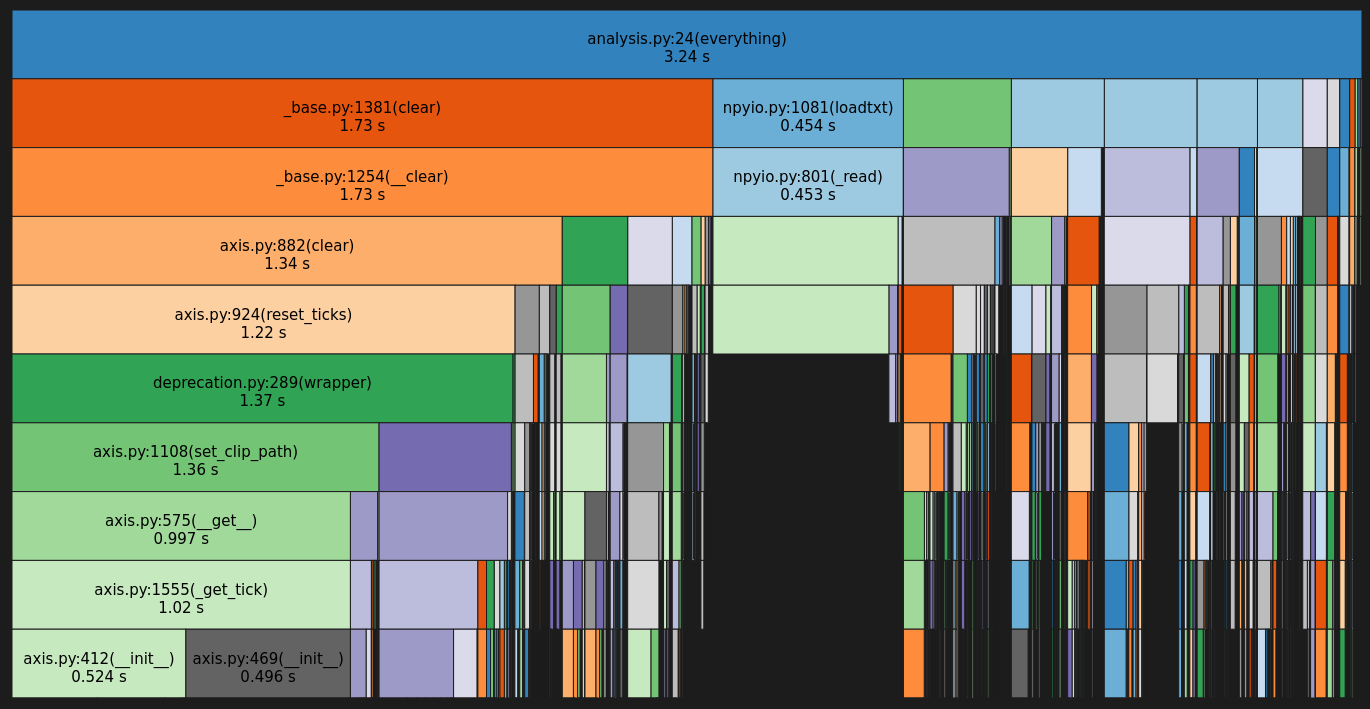

Cleaning the axes takes most of the time, but globally I've reduced the execution time. Looking at the remaining function calls, I can't really think of other obvious improvements.

Having optimized the loop and removed `plt.tight_layout()`, I've almost halved the total execution time (including the time needed to save the images):

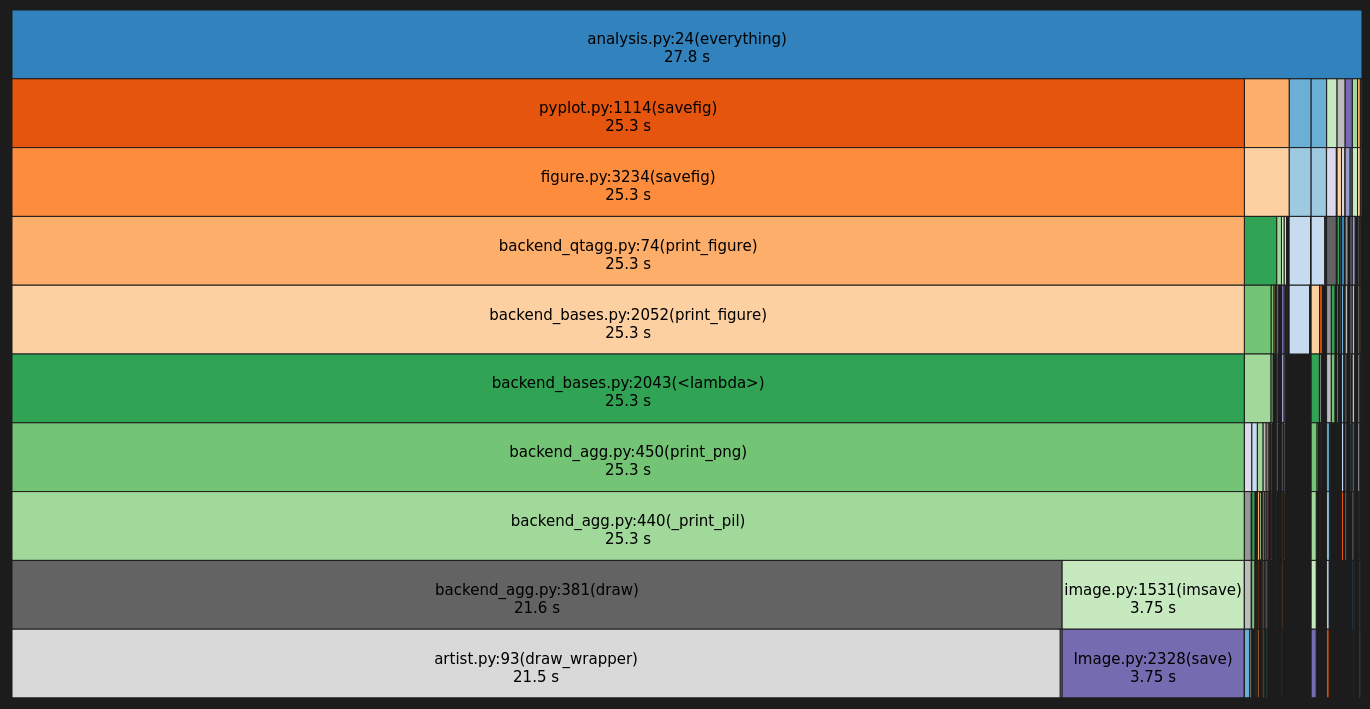

I'll try to use `numba` to speed up things even more now. I move all of the computations inside the function `work_on_data()` and compile it with `numba`:

```python
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})
import os
import yt
from numba import njit

@njit
def work_on_data(data):

	time, dMtde, M, delta_t = data

	#removing first element because dMtot is going to be one short
	time = time[1:]
	dMtde = dMtde[1:]
	delta_t = delta_t[1:]

	dMtot = M[1:] - M[:-1] #evaluates the difference between elements of M
	dMtot_no_tde = dMtot - dMtde * delta_t	#removes the contribution of TDEs, dMtde is the rate (mass over time)
	dMgas = np.where(dMtot_no_tde >= 1e5, 0, dMtot_no_tde) #sets the contribution of gas to 0 if the increase is larger than 1e5, otherwise it is dMtot_no_tde

	rateTot = dMtot / delta_t
	rateGas = dMgas / delta_t
	rateTDE = dMtde
	
	dMtde *= delta_t

	Mtot = np.cumsum(dMtot)
	Mgas = np.cumsum(dMgas)
	Mtde = np.cumsum(dMtde)
	
	return time, rateTot, rateGas, rateTDE, Mtot, Mgas, Mtde

def everything():

	ds=yt.load('output_00001/info_00001.txt')

	# Directory containing the files
	directory = './test_profile/'

	# Get all files starting with "BH" and ending with ".csv"
	files = [file for file in os.listdir(directory) if file.startswith('BH') and file.endswith('.csv') and not file.startswith('BH00000')]
	
	fig = plt.figure(figsize=(18.3, 10.3))
	ax1 = fig.add_subplot(211)
	ax2 = fig.add_subplot(212)

	redshifts = np.array([100, 30, 20, 15.5, 10, 9, 8, 7, 6, 5, 4, 3.5, 3, 2, 1, 0])
	z_ticks = [ds.cosmology.t_from_z(z).in_units('Gyr') for z in redshifts]

	axr = ax1.twiny()
	axr.set_xlabel(r"$z$")
	axr.set_xticks(z_ticks)
	axr.set_xticklabels(['${:g}$'.format(z) for z in redshifts])

	axr2 = ax2.twiny()
	axr2.set_xlabel(r"$z$")
	axr2.set_xticks(z_ticks)
	axr2.set_xticklabels(['${:g}$'.format(z) for z in redshifts])

	for file in files:
		print(file)
		data = np.loadtxt(os.path.join(directory, file), usecols=(41, 39, 0, 53), skiprows=1, unpack=True, delimiter=",")

		time, dMtot, dMgas, dMtde, Mtot, Mgas, Mtde = work_on_data(data)
        
		ax1.set_xlabel(r"$t [\mathrm{Gyr}]$")
		ax1.set_ylabel(r"mass growth rate $[\mathrm{M}_\odot / \mathrm{yr}]$")

		ax1.set_yscale("log")

		ax1.plot(time, dMtot, label="total")
		ax1.plot(time, dMgas, label="gas")
		ax1.plot(time, dMtde, label="tde")

		ax1.legend(loc="lower left")


		ax2.set_xlabel(r"$t [\mathrm{Gyr}]$")
		ax2.set_ylabel(r"accreted mass $[\mathrm{M}_\odot]$")

		ax2.set_yscale("log")

		ax2.plot(time, Mtot, label="total")
		ax2.plot(time, Mgas, label="gas")
		ax2.plot(time, Mtde, label="tde")

		ax2.legend(loc="lower right")

		tmin, tmax = time[0]-(time[-1]-time[0])/20, time[-1]+(time[-1]-time[0])/20
		ax2.set_xlim(tmin, tmax)
		axr.set_xlim(tmin, tmax)
		axr2.set_xlim(tmin, tmax)
		ax1.set_xlim(tmin, tmax)

		#plt.savefig("./test_profile/" + file[:-4] + ".png", dpi=100)
		
		ax1.clear()
		ax2.clear()
		
	return
	
import cProfile 
with cProfile.Profile() as pr:
    everything()  

pr.dump_stats('example.prof')
```

Compiling `work_on_data()` brings down the execution time of the function from 0.075 ms

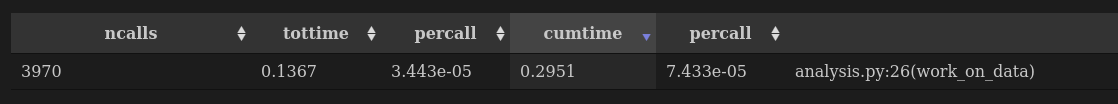

to 0.03 ms

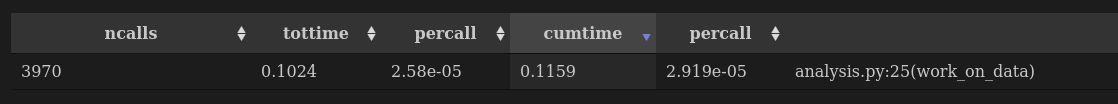

However, the compilation takes 4.2 s

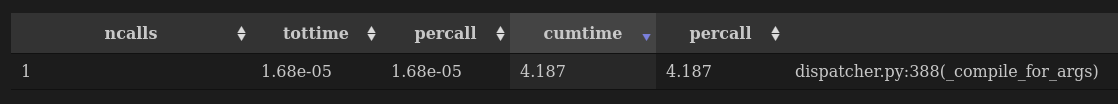

thus, this is a net loss of time even when considering the whole dataset of 4000 black holes. In order for `numba` to be worth it in this case, I would need to have about

$$ N = \frac{4.187}{(7.433-2.929)} \times 10^5 = 9.3 \times 10^5 $$

black holes in my dataset.